In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
device: cuda


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=../dataset \
                    --model_name={model_name} --subj=9 \
                    --no-blurry_recon \
                    --hidden_dim=1024 --n_blocks=4 --new_test --mode=vision"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all
--data_path=../dataset                     --model_name=pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all --subj=9                     --no-blurry_recon                     --hidden_dim=1024 --n_blocks=4 --new_test --mode=vision


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8,9,10,11],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--mode",type=str,default="all",
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [4]:


if subj < 9:
    voxels = {}
    # Load hdf5 data for betas
    f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
    # f = h5py.File(f'{data_path}/betas_3point6mm_subj01.hdf5', 'r')
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu")
    num_voxels = betas[0].shape[-1]
    voxels[f'subj0{subj}'] = betas
    print(f"num_voxels for subj0{subj}: {num_voxels}")

    if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
        if subj==3:
            num_test=2113
        elif subj==4:
            num_test=1985
        elif subj==6:
            num_test=2113
        elif subj==8:
            num_test=1985
        else:
            num_test=2770
        test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
    else: # using larger test set from after full dataset released
        if subj==3:
            num_test=2371
        elif subj==4:
            num_test=2188
        elif subj==6:
            num_test=2371
        elif subj==8:
            num_test=2188
        else:
            num_test=3000
        test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
        
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    from braceexpand import braceexpand
    test_url = [test_url] + list(braceexpand(f"{data_path}/wds/subj0{subj}/train/" + "{0.." + f"{nsessions_allsubj[subj-1]-1}" + "}.tar"))
    print("\nUSING ALL TRAINING SAMPLES\n")
        
    print(test_url)
    def my_split_by_node(urls): return urls
    test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
    print(f"Loaded test dl for subj{subj}!\n")
    vox_imagery, image_imagery = utils.load_nsd_mental_imagery(subject=subj, mode="imagery", stimtype="all", average=True, nest=False)
    num_test = 18
else:
    train_betas, train_images, test_betas, test_images = utils.load_imageryrf(subject=int(subj-8), mode=mode, mask=True, stimtype="object", average=False, nest=True, split=True)
    train_betas = torch.where(torch.isnan(train_betas), torch.zeros_like(train_betas), train_betas)
    test_betas = torch.where(torch.isnan(test_betas), torch.zeros_like(test_betas), test_betas)
    betas = torch.cat((train_betas, test_betas))
    all_images = torch.cat((train_images, test_images))
    data = torch.utils.data.TensorDataset(betas, all_images)
    num_test = len(test_betas)
    num_voxels = train_betas.shape[-1]
    test_dl = torch.utils.data.DataLoader(data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)



torch.Size([448, 8, 46909]) torch.Size([448, 3, 600, 600]) torch.Size([64, 8, 46909]) torch.Size([64, 3, 600, 600])


In [5]:
# Prep test voxels and indices of test images
if subj < 9:
    test_images_idx = []
    test_voxels_idx = []
    test_voxels = None
    for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
        test_vox = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
        if test_voxels is None:
            test_voxels = test_vox
        else:
            test_voxels = torch.vstack((test_voxels, test_vox))
        test_voxels_idx = np.append(test_images_idx, behav[:,0,5].cpu().numpy())
        test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
    test_images_idx = test_images_idx.astype(int)
    test_voxels_idx = test_voxels_idx.astype(int)

    # assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
    print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

In [6]:
# Load 73k NSD images
data_type = torch.float16
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [7]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_seq_dim = 256
clip_emb_dim = 1664
clip_img_embedder.to(device)

# import clip
# clip_model, preprocess = clip.load("ViT-L/14", device=device)
# preprocess = transforms.Compose([
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                          std=[0.26862954, 0.26130258, 0.27577711]),
# ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


In [8]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression([num_voxels], out_features=hidden_dim, seq_len=seq_len)

from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True)
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b,t = torch.Tensor([0.]), torch.Tensor([[0.],[0.]]), torch.Tensor([0.])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)
# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100
    
prior_network = PriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )

model.to(device)

# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'../train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")

checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
print("ckpt loaded!")

param counts:
48,035,840 total
48,035,840 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
501,396,120 total
501,396,120 trainable

---loading /export/raid1/home/kneel027/MindEye_Imagery/train_logs/pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all/last.pth ckpt---

ckpt loaded!


### Encoder

In [9]:
# encoder = RidgeRegression([clip_seq_dim*clip_emb_dim], out_features=hidden_dim, seq_len=1)
# utils.count_params(encoder)
# encoder.to(device)

# resume_model_name = "../train_logs/encoder_subj01_short_doubleclip"
# checkpoint = torch.load(f"{resume_model_name}/last.pth")
# encoder.load_state_dict(checkpoint['model_state_dict'])

# Main

In [10]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_images = None
all_blurryrecons = None
all_blurry_image_enc = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 24
num_samples_per_image = 1
plotting = True
if subj < 9:
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        for batch in tqdm(range(0,len(np.unique(test_images_idx)),minibatch_size)):
            start_time = time.time() 
            
            uniq_imgs = np.unique(test_images_idx)[batch:batch+minibatch_size]
            voxel = None
            for uniq_img in uniq_imgs:
                locs = np.where(test_images_idx==uniq_img)[0]
                if len(locs)==1:
                    locs = locs.repeat(3)
                elif len(locs)==2:
                    locs = locs.repeat(2)[:3]
                assert len(locs)==3
                if voxel is None:
                    voxel = test_voxels[None,locs] # 1, num_image_repetitions, num_voxels
                else:
                    voxel = torch.vstack((voxel, test_voxels[None,locs]))
            voxel = voxel.to(device)
            
            for rep in range(3):
                voxel_ridge = model.ridge(voxel[:,[rep]],0) # 0th index of subj_list
                
                # ENCODER #
                # image = torch.Tensor(images[uniq_imgs]).to(device)
                # clip_target0 = clip_img_embedder(image)
                # openclip_target = openclip_img_embedder(image)
                # clip_target = torch.cat((openclip_target, torch.hstack((clip_target0, torch.zeros(len(image),1664-768).to(device))).unsqueeze(1)), dim=1)
                # voxel_ridge = encoder(clip_target.flatten(1).unsqueeze(1))               
                                    
                backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                if rep==0:
                    clip_voxels = clip_voxels0
                    backbone = backbone0
                    blurry_image_enc = blurry_image_enc0[0]
                else:
                    clip_voxels += clip_voxels0
                    backbone += backbone0
                    blurry_image_enc += blurry_image_enc0[0]
            clip_voxels /= 3
            backbone /= 3
            blurry_image_enc /= 3
            
            if all_images is None:
                all_images = torch.Tensor(images[uniq_imgs])
            else:
                all_images = torch.vstack((all_images, torch.Tensor(images[uniq_imgs])))
                
            ## IMAGERY ##
            if subj < 9:
                if batch==0:
                    voxel = vox_imagery.to(device)
                    voxel_ridge = model.ridge(voxel[:,[0]],0) # 0th index of subj_list
                    
                    # ENCODER #
                    # image = transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR)(image_imagery)
                    # image = image.to(device)
                    # clip_target0 = clip_img_embedder(image)
                    # openclip_target = openclip_img_embedder(image)
                    # clip_target = torch.cat((openclip_target, torch.hstack((clip_target0, torch.zeros(len(image),1664-768).to(device))).unsqueeze(1)), dim=1)
                    # voxel_ridge = encoder(clip_target.flatten(1).unsqueeze(1))
                    
                    backboneI, clip_voxelsI, blurry_image_encI = model.backbone(voxel_ridge)
                    blurry_image_encI = blurry_image_encI[0]
                    all_images[:18] = transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR)(image_imagery)
                    clip_voxels[:18] = clip_voxelsI
                    backbone[:18] = backboneI
                    blurry_image_enc[:18] = blurry_image_encI
            
            ## IMAGERY ##
                    
            # Save retrieval submodule outputs
            if clip_scale>0:
                if all_clipvoxels is None:
                    all_clipvoxels = clip_voxels.cpu()
                else:
                    all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
else:
    num_data = len(train_betas) + len(test_betas)
    betas = torch.cat((train_betas, test_betas))
    all_images = torch.cat((train_images, test_images))
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        for voxel, _ in tqdm(test_dl):
            start_time = time.time() 
            # voxel = betas[batch*minibatch_size:min((batch+1)*minibatch_size, num_data)].to(device)
            voxel = voxel.to(device)
            
            for rep in range(voxel.shape[1]):
                voxel_ridge = model.ridge(voxel[:,[rep]],0) # 0th index of subj_list
                backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                if rep==0:
                    clip_voxels = clip_voxels0
                    backbone = backbone0
                    blurry_image_enc = blurry_image_enc0[0]
                else:
                    clip_voxels += clip_voxels0
                    backbone += backbone0
                    blurry_image_enc += blurry_image_enc0[0]
            clip_voxels /= voxel.shape[1]
            backbone /= voxel.shape[1]
            blurry_image_enc /= voxel.shape[1]

            # clip_voxels[batch*minibatch_size:max((batch+1)*minibatch_size, num_test)] = clip_voxels
            # backbone[batch*minibatch_size:max((batch+1)*minibatch_size, num_test)] = backbone
            # blurry_image_enc[batch*minibatch_size:max((batch+1)*minibatch_size, num_test)] = blurry_image_enc
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
            if all_backbones is None:
                all_backbones = backbone.cpu()
            else:
                all_backbones = torch.vstack((all_backbones, backbone.cpu()))
            if all_blurry_image_enc is None:
                all_blurry_image_enc = blurry_image_enc.cpu()
            else:
                all_blurry_image_enc = torch.vstack((all_blurry_image_enc, blurry_image_enc.cpu()))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


In [11]:
all_images_nsd = images[:10000]

# Imagery 

## Image retrieval

In [12]:
# get all the ground truth clip image embeddings of images seen by subj01
emb = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(all_images),128)):
        compare_images = all_images[batch:batch+128].to(device)

        emb0 = clip_img_embedder(compare_images)
        emb0 = nn.functional.normalize(emb0.flatten(1),dim=-1)
        
        if emb is None:
            emb = emb0
        else:
            emb = torch.vstack((emb, emb0))
emb.shape

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


torch.Size([512, 425984])

In [13]:
# Create cosine similarity matrix between brain embeddings and image embeddings
num_loops = 1
from scipy import stats
cos_sims = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(range(num_loops)):
        for batch in tqdm(range(0,len(all_images),128)):
            emb_ = all_clipvoxels[batch:batch+128].flatten(1) # CLIP-Brain
            
            emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

            assert emb.shape[-1] == emb_.shape[-1]

            if cos_sims is None:
                cos_sims = emb_ @ emb.T
            else:
                cos_sims = torch.vstack((cos_sims, emb_ @ emb.T))
        
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

cos_sims torch.Size([512, 512])
tensor([ 0.0330, -0.0903, -0.0816, -0.0836, -0.1108, -0.1099, -0.0750, -0.0806,
        -0.0898, -0.1160], device='cuda:0', dtype=torch.float16)


In [14]:
from PIL import Image, ImageDraw, ImageFont

print("image retrieval")
retrieved_samples = []
for gt_sample in range(num_test):
    retrieved_samples.append(int(torch.argmax(cos_sims[gt_sample, :]).item()))
all_retrieved_images = all_images[retrieved_samples]
all_images_grid = all_images[:num_test]

imsize = 150
if all_images_grid.shape[-1] != imsize:
    all_images_grid = transforms.Resize((imsize, imsize))(transforms.CenterCrop(all_images_grid.shape[2])(all_images_grid)).float()
if all_retrieved_images.shape[-1] != imsize:
    all_retrieved_images = transforms.Resize((imsize, imsize))(transforms.CenterCrop(all_retrieved_images.shape[2])(all_retrieved_images)).float()
print(all_images_grid.shape, all_retrieved_images.shape)
num_images = all_retrieved_images.shape[0]
num_rows = (2 * num_images + 11) // 12

# Interleave tensors
merged = torch.stack([val for pair in zip(all_images_grid, all_retrieved_images) for val in pair], dim=0)

# Calculate grid size
grid = torch.zeros((num_rows * 12, 3, all_retrieved_images.shape[-1], all_retrieved_images.shape[-1]))

# Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]

# Create the grid image with buffer
buffer_size = 5
grid_image_width = (all_retrieved_images.shape[-1] + buffer_size) * 12 - buffer_size
grid_image_height = (all_retrieved_images.shape[-1] + buffer_size) * num_rows - buffer_size
grid_image = Image.new('RGB', (grid_image_width, grid_image_height), color=(255, 255, 255))

# Paste images into the grid
for i, img in enumerate(grid_images):
    x = (all_retrieved_images.shape[-1] + buffer_size) * (i % 12)
    y = (all_retrieved_images.shape[-1] + buffer_size) * (i // 12)
    grid_image.paste(img, (x, y))

# Create title row image
title_height = 150
title_image = Image.new('RGB', (grid_image.width, title_height), color=(255, 255, 255))
draw = ImageDraw.Draw(title_image)
font = ImageFont.truetype("arial.ttf", 35)  # Change font size to 3 times bigger (15*3)
title_text = f" Test Set Image Retrieval, Model: {model_name}, Mode: {mode}"
bbox = draw.textbbox((0, 0), title_text, font=font)
text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
draw.text(((grid_image.width - text_width) / 2, (title_height - text_height) / 2), title_text, fill="black", font=font)

# Combine title and grid images
final_image = Image.new('RGB', (grid_image.width, grid_image.height + title_height))
final_image.paste(title_image, (0, 0))
final_image.paste(grid_image, (0, title_height))

final_image.save(f"../figs/{model_name}_{len(all_retrieved_images)}image_retrieval_{mode}.png")
if utils.is_interactive():
    display(final_image)
print(f"saved ../figs/{model_name}_{len(all_retrieved_images)}image_retrieval_{mode}.png")


/export/raid1/home/kneel027/miniconda3/envs/mindeye_imagery/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image retrieval
torch.Size([64, 3, 150, 150]) torch.Size([64, 3, 150, 150])


saved ../figs/pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all_64image_retrieval_vision.png


# Image Retrieval within NSD Natural Images

In [15]:
# get all the ground truth clip image embeddings of images seen by subj01
emb = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(all_images_nsd),128)):
        compare_images = all_images_nsd[batch:batch+128].to(device)

        emb0 = clip_img_embedder(compare_images)
        emb0 = nn.functional.normalize(emb0.flatten(1),dim=-1)
        
        if emb is None:
            emb = emb0.cpu()
        else:
            emb = torch.vstack((emb, emb0.cpu()))
emb.shape


  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [02:57<00:00,  2.24s/it]


torch.Size([10000, 425984])

In [16]:
# Create cosine similarity matrix between brain embeddings and image embeddings
num_loops = 1
from scipy import stats
cos_sims = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(range(num_loops)):
        for batch in tqdm(range(0,len(all_clipvoxels),128)):
            emb_ = all_clipvoxels[batch:batch+128].flatten(1) # CLIP-Brain
            
            emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

            assert emb.shape[-1] == emb_.shape[-1]

            if cos_sims is None:
                cos_sims = emb_ @ emb.to(device).T
            else:
                cos_sims = torch.vstack((cos_sims, emb_ @ emb.to(device).T))
        
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

cos_sims torch.Size([512, 10000])
tensor([-0.0884, -0.0822, -0.0812, -0.0688, -0.0750, -0.0896, -0.0840, -0.0804,
        -0.0886, -0.0901], device='cuda:0', dtype=torch.float16)


image retrieval
torch.Size([64, 3, 150, 150]) torch.Size([64, 3, 150, 150])


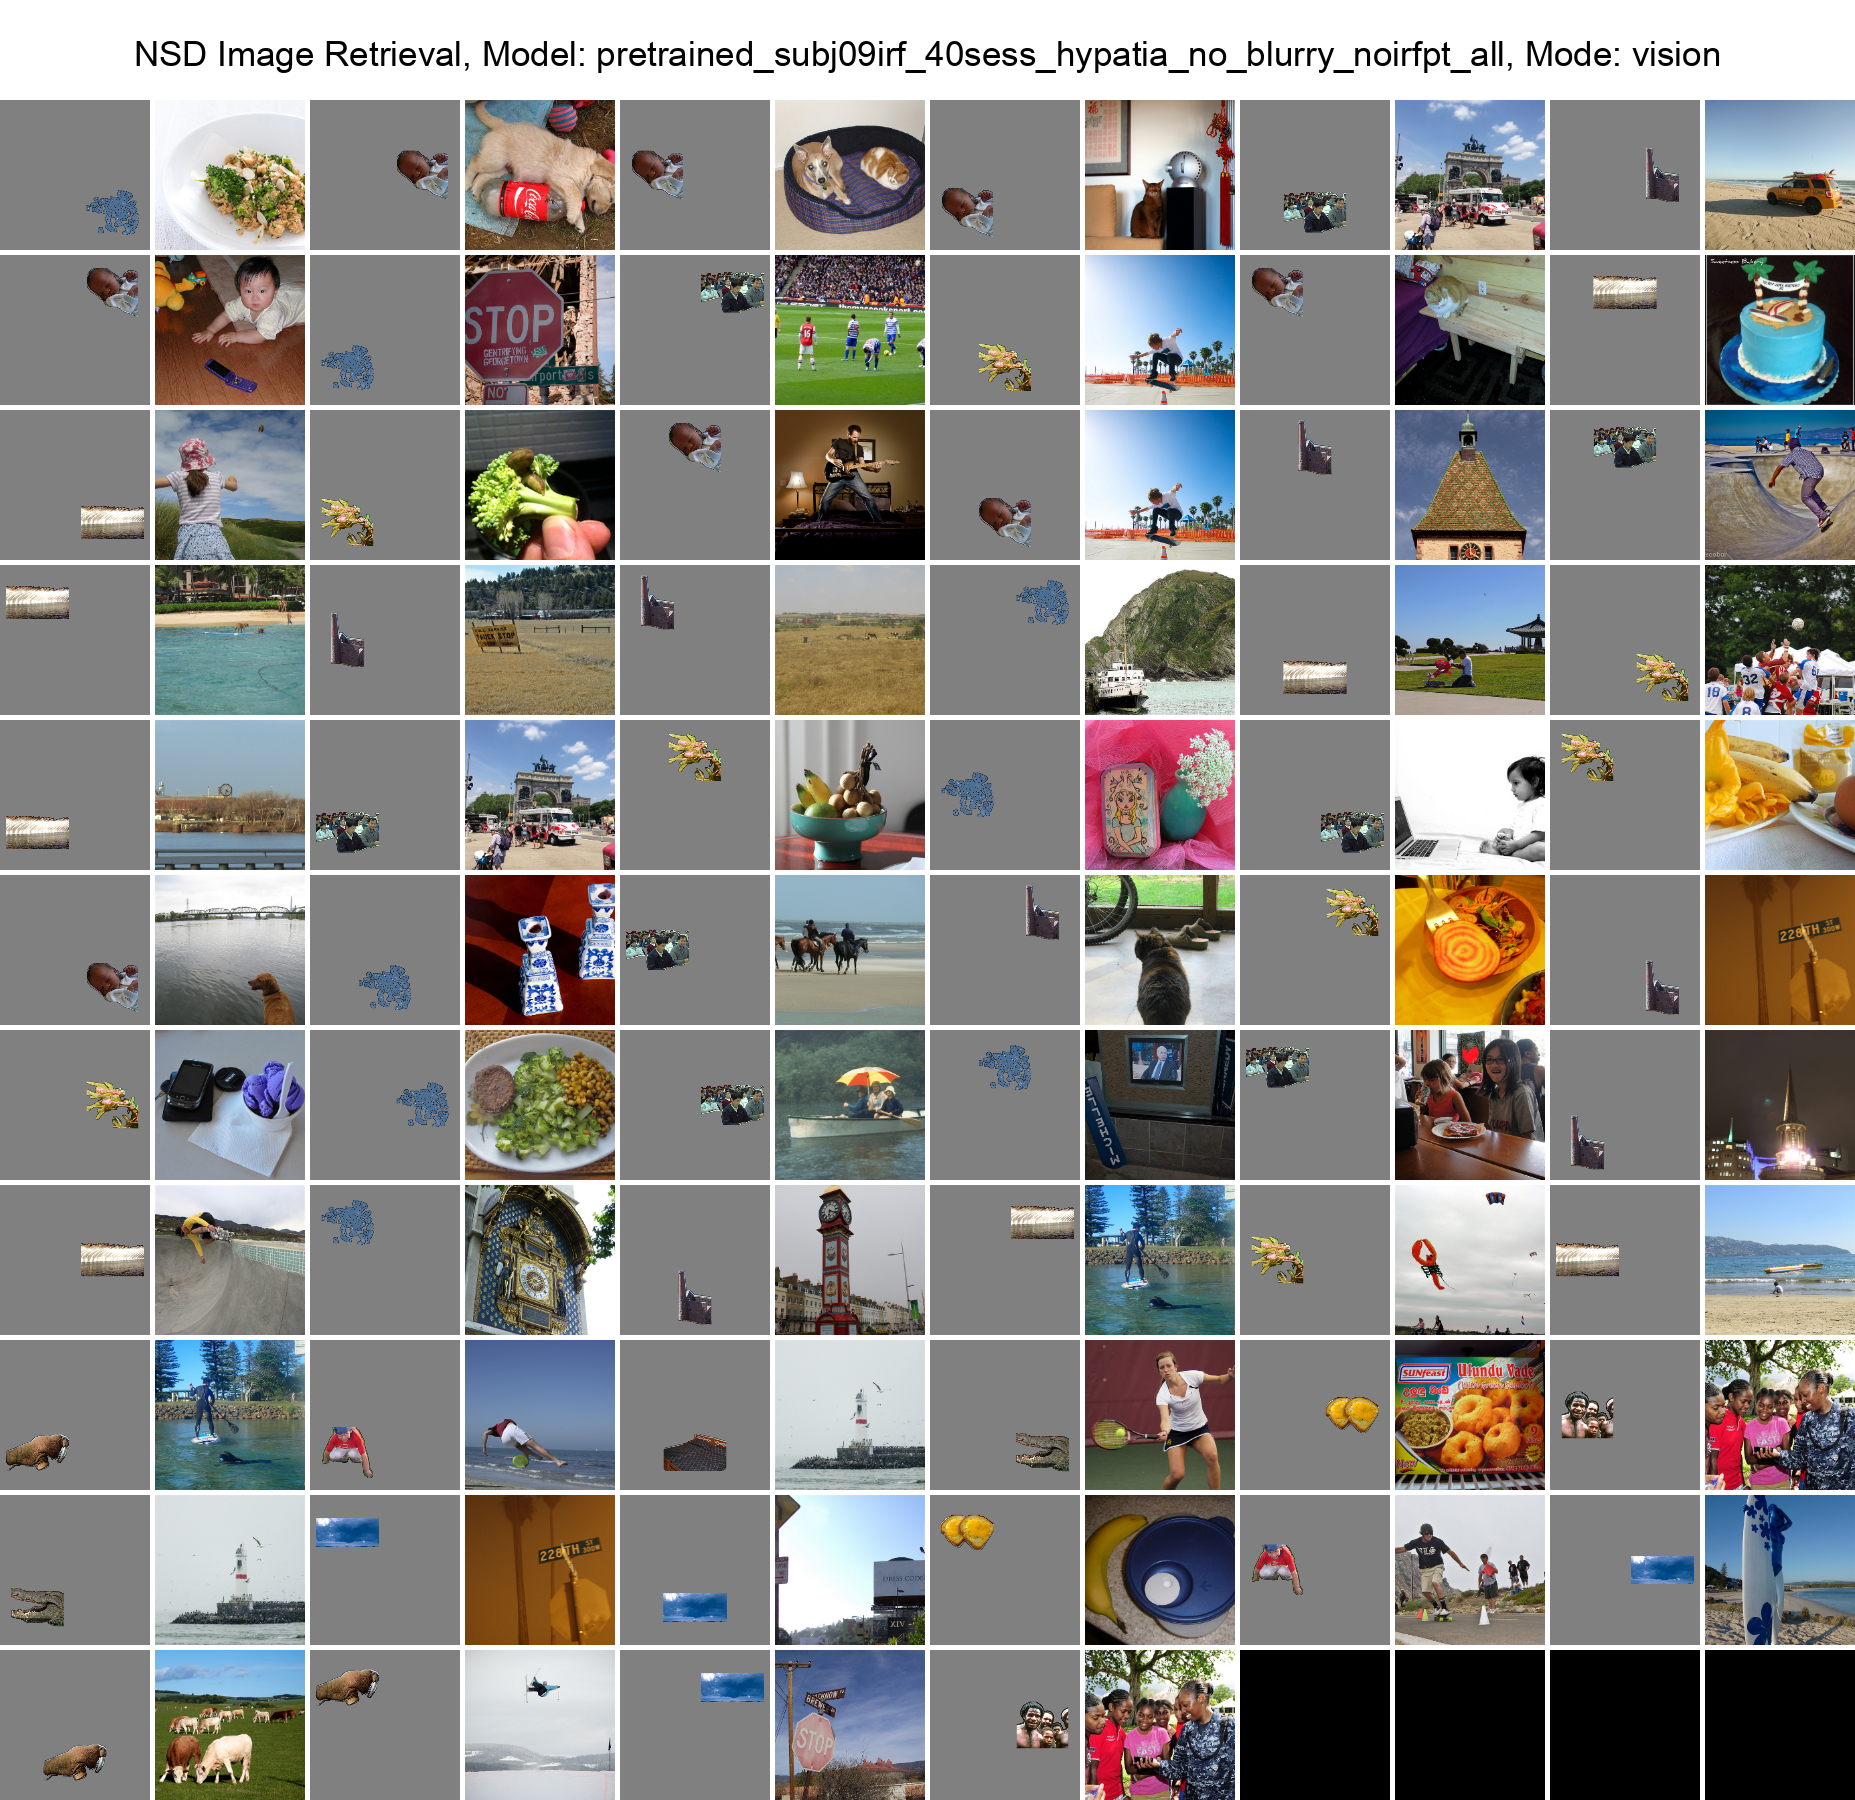

saved ../figs/pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all_64nsd_image_retrieval_vision.png


In [17]:

print("image retrieval")
retrieved_samples = []
for gt_sample in range(num_test):
    retrieved_samples.append(int(torch.argmax(cos_sims[gt_sample, :]).item()))
all_retrieved_images = all_images_nsd[retrieved_samples]

imsize = 150
if all_retrieved_images.shape[-1] != imsize:
    all_retrieved_images = transforms.Resize((imsize, imsize))(transforms.CenterCrop(all_retrieved_images.shape[2])(all_retrieved_images)).float()
print(all_images_grid.shape, all_retrieved_images.shape)
num_images = all_retrieved_images.shape[0]
num_rows = (2 * num_images + 11) // 12

# Interleave tensors
merged = torch.stack([val for pair in zip(all_images_grid, all_retrieved_images) for val in pair], dim=0)

# Calculate grid size
grid = torch.zeros((num_rows * 12, 3, all_retrieved_images.shape[-1], all_retrieved_images.shape[-1]))

# Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]

# Create the grid image with buffer
buffer_size = 5
grid_image_width = (all_retrieved_images.shape[-1] + buffer_size) * 12 - buffer_size
grid_image_height = (all_retrieved_images.shape[-1] + buffer_size) * num_rows - buffer_size
grid_image = Image.new('RGB', (grid_image_width, grid_image_height), color=(255, 255, 255))

# Paste images into the grid
for i, img in enumerate(grid_images):
    x = (all_retrieved_images.shape[-1] + buffer_size) * (i % 12)
    y = (all_retrieved_images.shape[-1] + buffer_size) * (i // 12)
    grid_image.paste(img, (x, y))

# Create title row image
title_height = 100
title_image = Image.new('RGB', (grid_image.width, title_height), color=(255, 255, 255))
draw = ImageDraw.Draw(title_image)
font = ImageFont.truetype("arial.ttf", 35)  # Change font size to 3 times bigger (15*3)
title_text = f"NSD Image Retrieval, Model: {model_name}, Mode: {mode}"
bbox = draw.textbbox((0, 0), title_text, font=font)
text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
draw.text(((grid_image.width - text_width) / 2, (title_height - text_height) / 2), title_text, fill="black", font=font)

# Combine title and grid images
final_image = Image.new('RGB', (grid_image.width, grid_image.height + title_height))
final_image.paste(title_image, (0, 0))
final_image.paste(grid_image, (0, title_height))

final_image.save(f"../figs/{model_name}_{len(all_retrieved_images)}nsd_image_retrieval_{mode}.png")
if utils.is_interactive():
    display(final_image)
print(f"saved ../figs/{model_name}_{len(all_retrieved_images)}nsd_image_retrieval_{mode}.png")


## Brain retrieval

In [18]:
# Create cosine similarity matrix between brain embeddings and brain embeddings
print("brain retrieval")
num_loops = 1
from scipy import stats
cos_sims = None
print(all_clipvoxels.shape, all_clipvoxels.flatten(1).shape)
emb = nn.functional.normalize(all_clipvoxels.flatten(1)).to(device)
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(all_clipvoxels),128)):
        emb_ = all_clipvoxels[batch:batch+128].flatten(1) # CLIP-Brain
        emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

        if cos_sims is None:
            cos_sims = emb_ @ emb.T
        else:
            cos_sims = torch.vstack((cos_sims, emb_ @ emb.T))
        
# assert len(cos_sims)==num_test
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

brain retrieval
torch.Size([512, 256, 1664]) torch.Size([512, 425984])


100%|██████████| 4/4 [00:00<00:00, 101.07it/s]

cos_sims torch.Size([512, 512])
tensor([1.0000, 0.2197, 0.2356, 0.2595, 0.0641, 0.1190, 0.2524, 0.2905, 0.1074,
        0.1650], device='cuda:0', dtype=torch.float16)


torch.Size([64, 3, 150, 150]) torch.Size([64, 3, 150, 150])


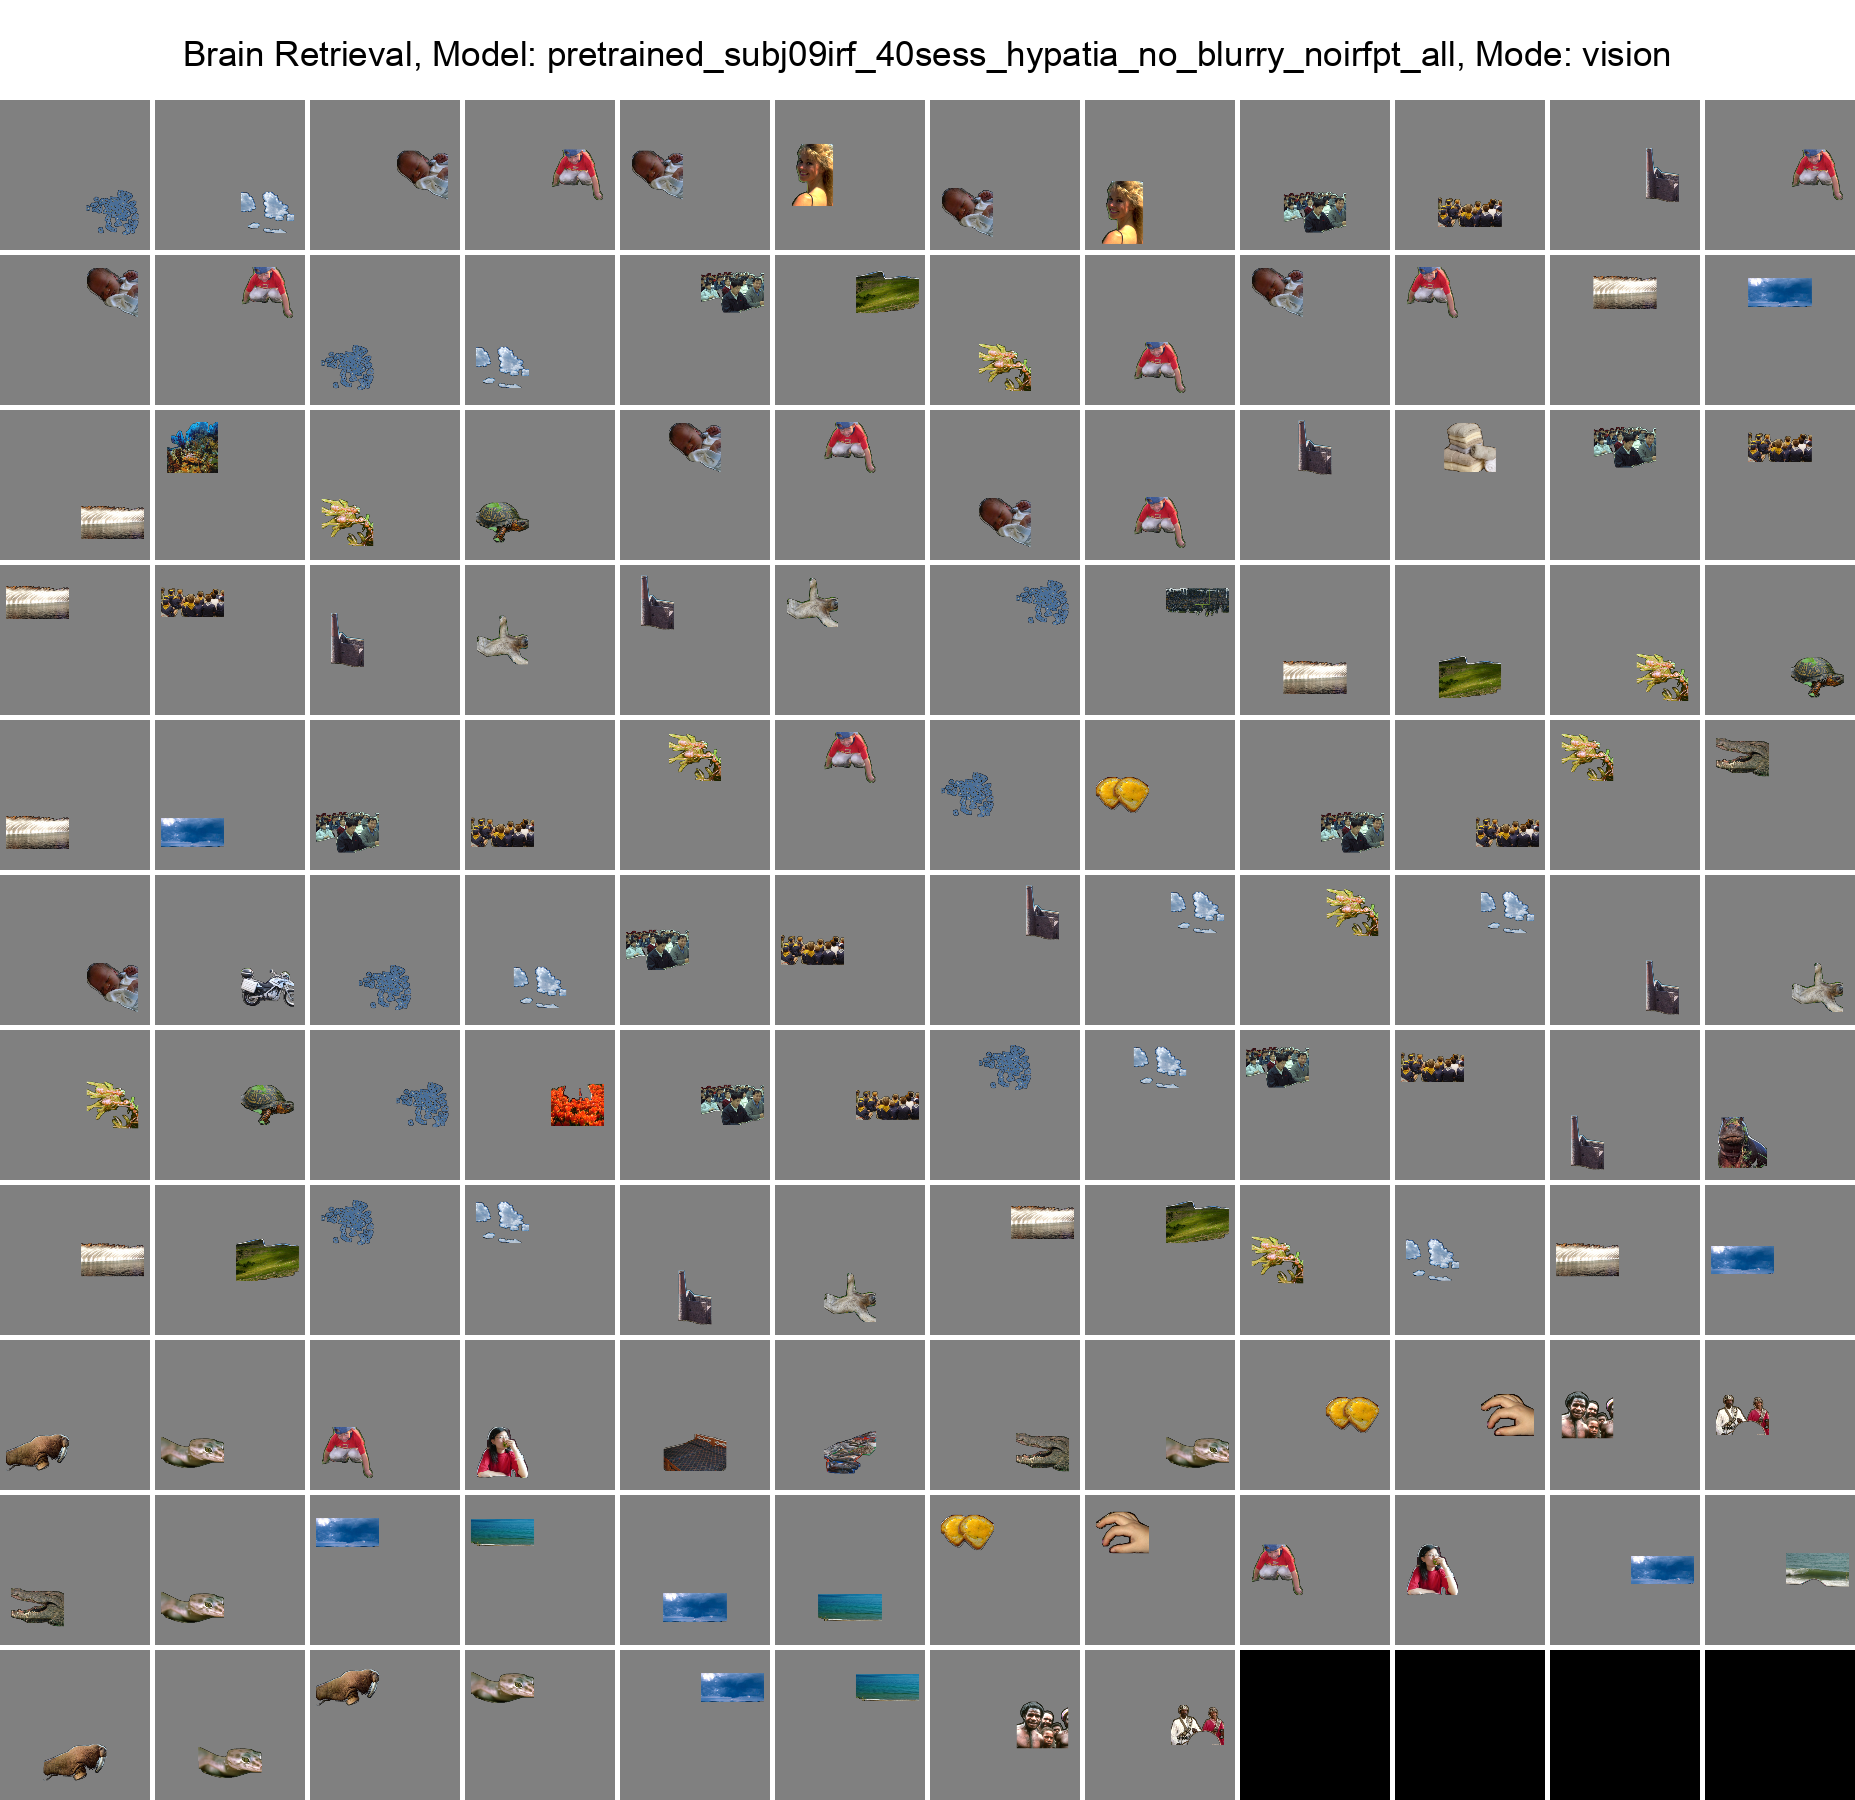

saved ../figs/pretrained_subj09irf_40sess_hypatia_no_blurry_noirfpt_all_64brain_retrieval_vision.png


In [19]:
from PIL import Image, ImageDraw, ImageFont

# Given a brain embedding, find the nearest brain embedding in the larger pool, THEN depict the image that was presented for that brain sample
retrieved_samples = []
for gt_sample in range(num_test):
    idx = int(torch.argmax(cos_sims[gt_sample, :]).item())
    jj = -2
    while idx < num_test:  # disallow finding nearest neighbor brain sample from test dataset
        idx = torch.argsort(cos_sims[gt_sample, :])[jj].item()
        jj -= 1
    retrieved_samples.append(idx)
all_retrieved_images = all_images[retrieved_samples]

imsize = 150
if all_retrieved_images.shape[-1] != imsize:
    all_retrieved_images = transforms.Resize((imsize, imsize))(transforms.CenterCrop(all_retrieved_images.shape[2])(all_retrieved_images)).float()
print(all_images_grid.shape, all_retrieved_images.shape)
num_images = all_retrieved_images.shape[0]
num_rows = (2 * num_images + 11) // 12

# Interleave tensors
merged = torch.stack([val for pair in zip(all_images_grid, all_retrieved_images) for val in pair], dim=0)

# Calculate grid size
grid = torch.zeros((num_rows * 12, 3, all_retrieved_images.shape[-1], all_retrieved_images.shape[-1]))

# Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]

# Create the grid image with buffer
buffer_size = 5
grid_image_width = (all_retrieved_images.shape[-1] + buffer_size) * 12 - buffer_size
grid_image_height = (all_retrieved_images.shape[-1] + buffer_size) * num_rows - buffer_size
grid_image = Image.new('RGB', (grid_image_width, grid_image_height), color=(255, 255, 255))

# Paste images into the grid
for i, img in enumerate(grid_images):
    x = (all_retrieved_images.shape[-1] + buffer_size) * (i % 12)
    y = (all_retrieved_images.shape[-1] + buffer_size) * (i // 12)
    grid_image.paste(img, (x, y))

# Create title row image
title_height = 100
title_image = Image.new('RGB', (grid_image.width, title_height), color=(255, 255, 255))
draw = ImageDraw.Draw(title_image)
font = ImageFont.truetype("arial.ttf", 35)  # Change font size to 3 times bigger (15*3)
title_text = f"Brain Retrieval, Model: {model_name}, Mode: {mode}"
bbox = draw.textbbox((0, 0), title_text, font=font)
text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
draw.text(((grid_image.width - text_width) / 2, (title_height - text_height) / 2), title_text, fill="black", font=font)

# Combine title and grid images
final_image = Image.new('RGB', (grid_image.width, grid_image.height + title_height))
final_image.paste(title_image, (0, 0))
final_image.paste(grid_image, (0, title_height))

final_image.save(f"../figs/{model_name}_{len(all_retrieved_images)}brain_retrieval_{mode}.png")
if utils.is_interactive():
    display(final_image)
print(f"saved ../figs/{model_name}_{len(all_retrieved_images)}brain_retrieval_{mode}.png")
